In [2]:
import sys
sys.path.append('~/workspace/GR-GAN')
from model import ITM_MODEL, G_NET
from miscc.utils import weights_init
from PIL import Image
from torch.autograd import Variable
import torch
import clip

In [3]:
EMBEDDING_DIM = 512
batch_size = 1
nz = 100

#######################################################
# Load ITM Model
######################################################
ITM = ITM_MODEL(EMBEDDING_DIM)

NET_E = '../models/ITM_model149.pth'
state_dict = \
    torch.load(NET_E, map_location=lambda storage, loc: storage)
ITM.load_state_dict(state_dict)
for p in ITM.parameters():
    p.requires_grad = False
print('Load clip encoder from:', NET_E)
ITM.cuda()
ITM.float()
ITM.eval()

#######################################################
# Load Generator
######################################################
netG = G_NET()
netG.apply(weights_init)
netG.cuda()
netG.eval()
with torch.no_grad():
    noise = Variable(torch.FloatTensor(batch_size, nz))
    noise = noise.cuda()

model_dir = '../output/coco_DMGAN_modelV2_CLIPV3_sl4_wl1_sl11_Adamax_sembs_300epoch/Model/checkpoint_0300.pth'
state_dict = \
    torch.load(model_dir, map_location=lambda storage, loc: storage)
netG.load_state_dict(state_dict['netG'])
print('Load G from: ', model_dir)

Load clip encoder from: ../models/ITM_model149.pth
Load G from:  ../output/coco_DMGAN_modelV2_CLIPV3_sl4_wl1_sl11_Adamax_sembs_300epoch/Model/checkpoint_0300.pth


In [4]:
def show_images(batch: torch.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

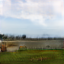

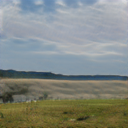

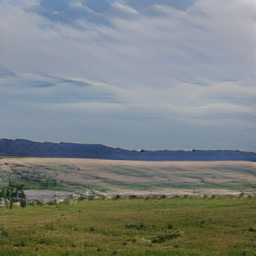

In [6]:
#######################################################
# Input Text
######################################################
caption = 'A scenic view of a grassland with mountains in the background.'
caption = clip.tokenize(caption)
caption = Variable(caption).cuda()
cap_lens = []
cap_lens.append(len(caption))
cap_lens = Variable(torch.Tensor(cap_lens)).cuda()

#######################################################
# Encode Text
######################################################
WORDS_NUM = 20
words_embs, sent_emb = ITM.sent_encode(caption)
words_embs, sent_emb = words_embs[:, :, 1:WORDS_NUM + 1].detach(), sent_emb.detach()
mask = (caption == 0)
num_words = words_embs.size(2)
if mask.size(1) > num_words:
    mask = mask[:, :num_words]
    
#######################################################
# Generate fake images
######################################################
noise.data.normal_(0, 1)
fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask, cap_lens)

# show_images(fake_imgs[0])
# show_images(fake_imgs[1])
show_images(fake_imgs[2])